In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from IPython.display import display
from scipy.optimize import differential_evolution, shgo, dual_annealing
from scipy.optimize import minimize
from scipy.integrate import quad, quadrature
import scipy.special as sc
from scipy.special import gamma, factorial


In [2]:
# Helper functions
def delta (i, j) :
    if i==j :
        return 1
    else :
        return 0
  
def secondDerivative (i, j, fun, params) :
    stepi = 0.0001*abs(params[i]) + 1e-10
    stepj = 0.0001*abs(params[j] ) + 1e-10
    parplusplus = params.copy()
    parplusminus = params.copy()
    parminusplus = params.copy()
    parminusminus = params.copy()
    parplusplus[i] = parplusplus[i] + stepi
    parplusplus[j] = parplusplus[j] + stepj
    parplusminus[i] = parplusminus[i] + stepi
    parplusminus[j] = parplusminus[j] - stepj 
    parminusplus[i] = parminusplus[i] - stepi
    parminusplus[j] = parminusplus[j] + stepj
    parminusminus[i] = parminusminus[i] - stepi
    parminusminus[j] = parminusminus[j] - stepj
    ret = (1/(4*stepi*stepj)) * (fun(parplusplus)+ fun(parminusminus) - fun(parplusminus)- fun(parminusplus))
    return ret
    
def getHessian(fun, params) : 
    dim = len(params)
    hess = np.zeros([dim,dim])
    for i in range(dim) :
        for j in range(dim) :
            hess[i][j] = secondDerivative(i, j, fun, params)/2.0
    #print(hess)
    return hess
    

In [3]:
class DatasetGenerator :
    ''' 
    argument : 
    - theoryParams : list of theory parameter
    - theoryPrediction : a function (double x, List(double))
    - xGrid : list of x 
    - stats : list of the statistical error
    - systFluct : list of systematic fluctuation 
    - **syst : dictionary of systematic error
    '''
    def __init__(self, theoryParams, theoryPredictions, xGrid, stats, normError, normFluct, systFluct, seed, *syst) : #dataPd must of the form numpy array: xGrid , data
        self.theoryParams = theoryParams # theory params
        self.xGrid = np.array(xGrid) # grid of x
        self.statsSpread = np.array(stats)  #statistical error
        self.normError = normError
        self.normFluct = normFluct
        self.systFluct = np.array(systFluct) #systeatic fluctuation
        self.theoryPredictions = theoryPredictions #theory prediction        
        self.systSpread= np.array([sys for sys in syst]) #systematic error 
        
        self.syst= np.array([self.systFluct[i]*self.systSpread[i] for i in range(len(self.systSpread))])# systematic fluctuation * systematic error
        #print(self.systSpread, len(self.systSpread), self.syst)
        np.random.seed(seed)
        self.stats = np.array([np.random.normal()*el for el in self.statsSpread])
        self.numSyst = len(self.systSpread)
        self.numData = len(xGrid)
        assert (len(xGrid) == len(self.statsSpread))
        assert (len(self.systFluct) == len(self.systSpread)) 
        #print ("Real statistical error : ", self.stats)
        #print ("Real systematic error : ", self.syst)
        self.totErr = []
        for i in range(len(xGrid)) :
            c = self.statsSpread[i]**2
            for sys in self.systSpread: 
                c = c+ sys[i]**2
            self.totErr.append(c**(0.5))            
        self.generateDataset()
        self.getCovarianceMatrix()

        h=0

        for i in range(len(xGrid)) : 
            for j in range(len(xGrid)) : 
                h=h+self.corrInv[i, j]
        #print("hessinvsqrt", np.sqrt(1/h))
        
        
        plt.figure()
        plt.errorbar(self.xGrid, self.data, self.totErr, linestyle=" ", marker= "o", label="Data" )
        plt.plot(self.xGrid, self.theo, label="Generator")
        plt.show()

    
    def generateData (self) :
        systNorm = self.normError*self.normFluct
        self.theo = (1.0+systNorm)*np.array([self.theoryPredictions(x, self.theoryParams) for x in self.xGrid ]  )
        self.data = self.theo + self.stats
        for syst in self.syst :
            self.data = self.data + syst
        return self.data
        
    def generateDataset(self) :
        self.generateData()
        self.dataset= [self.xGrid, self.data, self.theo, self.statsSpread] #xGrid, data, theo, stats, syst
        cols = ["x", "data", "theory", "stats" ]
        for i in range(self.numSyst):
            self.dataset.append(self.systSpread[i])
            cols.append("syst_"+str(i))       
        #print(np.array(self.dataset))
        self.dataDF = pd.DataFrame(np.array(self.dataset).T, columns= cols)
        #display(self.dataDF)
        
    def generateReplica(self) :
        newsystnorm = self.normError*np.random.normal()
        stat = np.array([np.random.normal()*el for el in self.statsSpread])
        systFluct = np.array([np.random.normal() for i in range(self.numSyst)])
        #print("syt fluct : ", systFluct)
        syst = np.array([systFluct[i]*self.systSpread[i] for i in range(self.numSyst)])
        data = (1.0+newsystnorm)*self.theo + stat
        for i in range(self.numSyst) :
            data = data + syst[i]
        return data 
    
    def generateReplicaFromData(self) :
        stat = np.array([np.random.normal()*el for el in self.statsSpread])
        systFluct = np.array([np.random.normal() for i in range(self.numSyst)])
        #print("syt fluct : ", systFluct)
        syst = np.array([systFluct[i]*self.systSpread[i] for i in range(self.numSyst)])
        data = self.data + stat
        for i in range(self.numSyst) :
            data = data + syst[i]
        return data 
    
    def getCovarianceMatrix (self):
        self.corr = np.zeros([self.numData,self.numData])
        for i in range(self.numData) :
            for j in range(self.numData) :
                systcorr= 0.0
                for a in range(self.numSyst) :
                    systcorr = systcorr + self.systSpread[a][i]*self.systSpread[a][j]
                self.corr[i, j] =  delta(i,j)*(self.statsSpread[i]**2)+ systcorr      
        self.corrInv = np.linalg.inv(self.corr) 


class ChiSquare :   
    def __init__(self, dataGenerator, theoryPredictions):
        self.dataGen = dataGenerator
        self.theo = theoryPredictions
        self.data = self.dataGen.data
        self.xGrid = self.dataGen.xGrid
        self.numPoints = len(self.dataGen.xGrid)
        self.getCovarianceMatrix()
        #print(self.corr)
        self.isNormFit = False
                
    def getCovarianceMatrix (self): #pure virtual function
        raise NotImplementedError                  
                    
    def chi2(self, params):#pure virtual function
        raise NotImplementedError 
        
class ChiSquareDmethod  (ChiSquare):   
    def __init__(self, dataGenerator, theoryPredictions ):
        super().__init__(dataGenerator, theoryPredictions)
                
    def getCovarianceMatrix (self): #pure virtual function
        self.corr = self.dataGen.corr.copy()
        self.corrInv = self.dataGen.corrInv.copy() 
                    
    def chi2(self, params):
        N = len(self.data)
        theory = np.array([self.theo(x, params) for x in self.xGrid]) 
        A = 1+ (self.dataGen.normError**2) * np.dot(self.data,np.dot(self.corrInv, self.data) )
        B =  1+ (self.dataGen.normError**2) * np.dot(self.data,np.dot(self.corrInv, theory) ) 
        E =  1+ (self.dataGen.normError**2) * np.dot(theory,np.dot(self.corrInv, theory) )
        ret = (1/(self.dataGen.normError**2)) * (E-(B**2)/A)                           
        return ret 
    
class ChiSquareTmethod  (ChiSquare):   
    def __init__(self, dataGenerator, theoryPredictions ):
        super().__init__(dataGenerator, theoryPredictions)
                
    def getCovarianceMatrix (self): #pure virtual function
        self.corr = self.dataGen.corr.copy()
        self.corrInv = self.dataGen.corrInv.copy() 
                    
    def chi2(self, params):
        N = len(self.data)
        theory = np.array([self.theo(x, params) for x in self.xGrid]) 
        A = 1+ (self.dataGen.normError**2) * np.dot(self.data,np.dot(self.corrInv, self.data) )
        B =  1+ (self.dataGen.normError**2) * np.dot(self.data,np.dot(self.corrInv, theory) ) 
        E =  1+ (self.dataGen.normError**2) * np.dot(theory,np.dot(self.corrInv, theory) )
        ret = (1/(self.dataGen.normError**2)) * (A-(B**2)/E)                
        return ret 
    
class ChiSquareT0method  (ChiSquare):   
    def __init__(self, dataGenerator, theoryPredictions, useCorr = True):
        self.useCorr = useCorr
        super().__init__(dataGenerator, theoryPredictions)
                
    def getCovarianceMatrix (self):
        self.corr = self.dataGen.corr.copy()
        normErrorAbs = []
        for point in self.data : 
            normErrorAbs.append(self.dataGen.normError*point)
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                self.corr[i, j] = self.corr[i, j] + normErrorAbs[i]*normErrorAbs[j]
        self.corrInv= np.linalg.inv(self.corr)                
        if not self.useCorr : #if correlation is ignored
            for i in range(self.numPoints ) :
                for j in range(self.numPoints ) :
                    if (i != j) :
                        self.corr[i][j] = 0.0
                        self.corrInv[i][j] = 0.0 
                        
    def updateCovarianceMatrix (self, theory ) : 
        corr = self.dataGen.corr.copy()
        normErrorAbs = []
        for point in theory : 
            normErrorAbs.append(self.dataGen.normError*point)
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                corr[i, j] = corr[i, j] + normErrorAbs[i]*normErrorAbs[j]
        corrInv= np.linalg.inv(corr)                
        if not self.useCorr : #if correlation is ignored
            for i in range(self.numPoints ) :
                for j in range(self.numPoints ) :
                    if (i != j) :
                        corr[i][j] = 0.0
                        corrInv[i][j] = 0.0 
        return corr, corrInv
    
    def fixTheory(self, params) : 
        theory = np.array([self.theo(x, params) for x in self.xGrid])
        self.corr, self.corrInv = self.updateCovarianceMatrix(theory)   
                    
    def chi2(self, params):#pure virtual function
        theory = np.array([self.theo(x, params) for x in self.xGrid])
        chi2 = np.dot( (self.data-theory), np.dot(self.corrInv, (self.data-theory)))
        return chi2
        
class ChiSquareDAgostini(ChiSquare) :   
    def __init__(self, dataGenerator, theoryPredictions ):
        super().__init__(dataGenerator, theoryPredictions)
        self.isNormFit = True
                
    def getCovarianceMatrix (self): #pure virtual function
        self.corr = self.dataGen.corr.copy()
        self.corrInv = self.dataGen.corrInv.copy()                   
                    
    def chi2(self, params):
        theoryParams = []
        for i in range(len(params)-1) :
            theoryParams.append(params[i])
        theory = np.array([self.theo(x, theoryParams) for x in self.xGrid]) /params[len(params)-1]
        chi2 = np.dot( (self.data-theory), np.dot(self.corrInv, (self.data-theory))) + ((1-params[len(params)-1])/self.dataGen.normError)**2
        return chi2 
    
class ChiSquareDAgostini2(ChiSquare) :   
    def __init__(self, dataGenerator, theoryPredictions ):
        super().__init__(dataGenerator, theoryPredictions)
        self.isNormFit = True
                
    def getCovarianceMatrix (self): #pure virtual function
        self.corr = self.dataGen.corr.copy()
        self.corrInv = self.dataGen.corrInv.copy()                   
                    
    def chi2(self, params):
        theoryParams = []
        for i in range(len(params)-1) :
            theoryParams.append(params[i])
        theory = np.array([self.theo(x, theoryParams) for x in self.xGrid]) *params[len(params)-1]
        chi2 = np.dot( (self.data-theory), np.dot(self.corrInv, (self.data-theory))) + ((1-params[len(params)-1])/self.dataGen.normError)**2
        return chi2 
    
class ChiSquareTest(ChiSquare) :      
    def __init__(self, dataGenerator, theoryPredictions ):
        super().__init__(dataGenerator, theoryPredictions)
        self.isNormFit = True
                
    def getCovarianceMatrix (self): #pure virtual function
        self.corr = self.dataGen.corr.copy()
        self.corrInv = self.dataGen.corrInv.copy()                   
                    
    def chi2(self, params):
        N = len(self.data)
        theoryParams = []
        for i in range(len(params)-1) :
            theoryParams.append(params[i])
        theory = np.array([self.theo(x, theoryParams) for x in self.xGrid]) *params[len(params)-1]
        chi2 = np.dot( (self.data-theory), np.dot(self.corrInv, (self.data-theory))) + ((1-params[len(params)-1])/self.dataGen.normError)**2
        return chi2 
    
class ChiSquareProfML(ChiSquare) :   
    def __init__(self, dataGenerator, theoryPredictions ):
        super().__init__(dataGenerator, theoryPredictions)
        self.isNormFit = False
                
    def getCovarianceMatrix (self): #pure virtual function
        self.corr = self.dataGen.corr.copy()
        self.corrInv = self.dataGen.corrInv.copy()                   
                    
    def chi2(self, theoryParams):
        N = len(self.data)
        theory = np.array([self.theo(x, theoryParams) for x in self.xGrid])
        A = 1+self.dataGen.normError**2 * np.dot(self.data, np.dot(self.corrInv, theory))
        B = 1+self.dataGen.normError**2 * np.dot(self.data, np.dot(self.corrInv, self.data))
        rplus = (A/(2*B))*(1+np.sqrt(1+4*N*self.dataGen.normError**2*B/(A**2) ))
        #rminus = (A/(2*B))*(1-np.sqrt(1+4*N*self.dataGen.normError**2*B/(A**2) ))
        #print ("rplus and rminus", rplus, rminus)
        residual = self.data*rplus - theory
        chi2 = np.dot(residual, np.dot(self.corrInv, residual)) + ((1-rplus)/self.dataGen.normError)**2-2*N*np.log(abs(rplus))
        return chi2 
    
class ChiSquareIntegratedML(ChiSquare) :   
    def __init__(self, dataGenerator, theoryPredictions ):
        super().__init__(dataGenerator, theoryPredictions)
                
    def getCovarianceMatrix (self): #pure virtual function
        self.corr = self.dataGen.corr.copy()
        self.corrInv = self.dataGen.corrInv.copy() 
                    
    def chi2(self, params):
        N = len(self.data)
        theory = np.array([self.theo(x, params) for x in self.xGrid]) 
        A = 1+ (self.dataGen.normError**2) * np.dot(self.data,np.dot(self.corrInv, self.data) )
        B =  1+ (self.dataGen.normError**2) * np.dot(self.data,np.dot(self.corrInv, theory) ) 
        E =  1+ (self.dataGen.normError**2) * np.dot(theory,np.dot(self.corrInv, theory) )
        alpha = A/(2.0*self.dataGen.normError**2)
        r0 = B/A
        #hp = hyp1f1(-N/2.0, 0.5, -alpha*power(r0,2))#* power(alpha, -(N+1)/2) *gamma((N+1)/2.0)
        penterm =-2*N*np.log(np.abs(r0))# -2*log(hp)
        ret = (1/(self.dataGen.normError**2)) * ((E*A-B**2)/A) + penterm
        #print(alpha**(-(N+1)/2))
        #print("HP : ", hp)
        #print("r0 : ", r0)
        #print("Pentterm : ", penterm, "\n")       
                            
        return ret 

            
class ChiSquareCorr (ChiSquare):
    def __init__(self, dataGenerator, theoryPredictions, useCorr = True):
        self.useCorr = useCorr
        super().__init__(dataGenerator, theoryPredictions)
        
    def getCovarianceMatrix (self):
        self.corr = self.dataGen.corr.copy()
        self.corrInv = self.dataGen.corrInv.copy()
        if not self.useCorr : #if correlation is ignored
            for i in range(self.numPoints ) :
                for j in range(self.numPoints ) :
                    if (i != j) :
                        self.corr[i][j] = 0.0
                        self.corrInv[i][j] = 0.0                        
                    
    def chi2(self, theoryParams):
        theory = np.array([self.theo(x, theoryParams) for x in self.xGrid])
        chi2 = np.dot( (self.data-theory), np.dot(self.corrInv, (self.data-theory)))
        return chi2
     

class ChiSquareCorrFit (ChiSquare):
    def __init__(self, dataGenerator, theoryPredictions, numTheoParam):
        super().__init__(dataGenerator, theoryPredictions)  
        self.numTheoParams = numTheoParam 

    def getCovarianceMatrix (self):
        self.corr = np.diag(np.array([sig**2 for sig in self.dataGen.statsSpread ]))
        self.corrInv = np.diag(np.array([1/(sig**2) for sig in self.dataGen.statsSpread]))                
                    
    def chi2(self, params):
        theoparams = np.array([params[i] for i in range(self.numTheoParams)])
        corrParams = np.array([params[i] for i in range(self.numTheoParams, self.numTheoParams + self.dataGen.numSyst )])
        theory = np.array([self.theo(x, params) for x in xGrid])
        residual = self.data-theory
        for i in range (self.dataGen.numSyst) :
            residual = residual - corrParams[i] * self.dataGen.systSpread[i]
        chi2 = np.dot( residual, np.dot(self.corrInv, residual)) + np.dot(corrParams, corrParams)
        return chi2



class GlobalAnalysis :
    def __init__(self,tol, *chisqr ):
        self.chisqrs = [chi2 for chi2 in chisqr]
        self.chisqrNorm = []
        for chi2 in self.chisqrs :
            if chi2.isNormFit : 
                self.chisqrNorm.append(chi2)
        self.numNormParams = len(self.chisqrNorm)
        self.tol = tol
        self.theoXGrid = np.logspace(-1,-0.0000000001,200)
        self.numCall=0
        
    def chi2(self, params):
        totalchi2 = 0
        theoParams = []
        normParams = []
        for i in range(self.numTheoParams) : 
            theoParams.append(params[i])
        for i in range(self.numTheoParams, len(params)) : 
            normParams.append(params[i])
        j = 0
        for Chi2 in self.chisqrs : 
            if (Chi2.isNormFit) : 
                newParams = theoParams.copy()
                newParams.append(normParams[j])
                totalchi2 = totalchi2 + Chi2.chi2(newParams)
                j= j+1
            else : 
                totalchi2 = totalchi2 + Chi2.chi2(theoParams)
                
        assert(j== self.numNormParams )
        self.numCall = self.numCall +1
        return totalchi2            
    
    def runFit (self, bounds, useTrueTheoReplica=True, local = True):
        self.numParams = len(bounds)
        self.numTheoParams = self.numParams-self.numNormParams
        if (local) :
            result = minimize(self.chi2, bounds, method="Nelder-Mead")
            result = minimize(self.chi2, result.x, method="Nelder-Mead")
            result = minimize(self.chi2, result.x, method="Nelder-Mead")
            result = minimize(self.chi2, result.x, method="L-BFGS-B")
        else : 
            result = differential_evolution(self.chi2, bounds)
            result = minimize(self.chi2, result.x, method="L-BFGS-B")
            #result = minimize(self.chi2, result.x, method="trust-constr")
        self.parAtMin = result.x
        self.funAtMin = result.fun
        print ("Parameter at minimum : ", result.x)
        print ("Chisqr at minimum : ", result.fun)  
        print ("Chisqr per dof : ", result.fun/(self.getNumberOfPoints()-self.numParams))
        print("Number of Function Calls : ", self.numCall)
        self.getParameterError()
        self.runReplicaFits(bounds, 200, useTrueTheoReplica )
        self.plotDataTheory()
               
    def runFitT0method(self, bounds, iteration=5):
        self.numParams = len(bounds)
        self.numTheoParams = self.numParams
        result = differential_evolution(self.chi2, bounds)
        result = minimize(self.chi2, result.x, method="L-BFGS-B")
        result = minimize(self.chi2, result.x, method="trust-constr")
        
        for i in range(iteration): 
            for Chi2 in self.chisqrs : 
                Chi2.fixTheory(result.x)
            result = differential_evolution(self.chi2, bounds)
            result = minimize(self.chi2, result.x, method="L-BFGS-B")
            #result = minimize(self.chi2, result.x, method="trust-constr")
            print(str(i) + "-iteration : ", result.x )
            
        self.parAtMin = result.x
        self.funAtMin = result.fun
        print ("Parameter at minimum : ", result.x)
        print ("Chisqr at minimum : ", result.fun)  
        print ("Chisqr per dof : ", result.fun/(self.getNumberOfPoints()-self.numParams))
        print("Number of Function Calls : ", self.numCall)
        self.getParameterError()
        self.plotDataTheory()
    
    def runFitTestmethod(self, bounds, iteration=20): 
        self.numParams = len(bounds)
        self.numTheoParams = len(bounds)-self.numNormParams
        result = differential_evolution(self.chi2, bounds)
        result = minimize(self.chi2, result.x, method="L-BFGS-B")
        #result = minimize(self.chi2, result.x, method="trust-constr")     
        for i in range(iteration): 
            for Chi2 in self.chisqrs : 
                Chi2.updater0(result.x)
                print (Chi2.r0)
            result = differential_evolution(self.chi2, bounds)
            result = minimize(self.chi2, result.x, method="L-BFGS-B")
            #result = minimize(self.chi2, result.x, method="trust-constr")
            print(str(i) + "-iteration : ", result.x )
            
        self.parAtMin = result.x
        self.funAtMin = result.fun
        print ("Parameter at minimum : ", result.x)
        print ("Chisqr at minimum : ", result.fun)  
        print ("Chisqr per dof : ", result.fun/(self.getNumberOfPoints()-self.numParams))
        print("Number of Function Calls : ", self.numCall)
        self.getParameterError()
        self.plotDataTheory()
            
        
            
        
    
    def plotDataTheory(self) :
        self.getTheoryError()
        for i, Chi2 in zip(range(len(self.chisqrs)), self.chisqrs) : 
            #print(self.theoError[i])
            newtheo = np.array([Chi2.theo(x, self.parAtMin) for x in self.theoXGrid])
            trueTheo = np.array([Chi2.dataGen.theoryPredictions(x, Chi2.dataGen.theoryParams) for x in self.theoXGrid])
            data = Chi2.dataGen.data           
            plt.figure(figsize=(6,4))
            plt.plot(self.theoXGrid,  trueTheo, color="blue", label="True Theory")
            plt.errorbar(Chi2.dataGen.xGrid, data, Chi2.dataGen.totErr, linestyle=" ", marker= "o", label="Data", color="grey", alpha=0.5)
            #plt.scatter (self.xGrid, self.data)
            plt.semilogx(self.theoXGrid, newtheo, color="red", label="Fit")
            plt.fill_between(self.theoXGrid,newtheo+self.theoError[i], newtheo-self.theoError[i], color="red", alpha=0.2)

           

            plt.plot(self.theoXGrid,  self.theoMean[Chi2], color="green", label="Fit-replica")
            plt.fill_between(self.theoXGrid, self.theoMean[Chi2] + self.theoStd[Chi2], self.theoMean[Chi2] - self.theoStd[Chi2], color="green", alpha=0.2)

            plt.legend(fontsize=10)
            plt.show()
            
        
    def getNumberOfPoints (self):
        self.numPoints = 0
        for Chi2 in self.chisqrs : 
               self.numPoints = self.numPoints + Chi2.numPoints
        return self.numPoints
    
    def getTheoryError(self) :
        self.theoError = []
        for Chi2 in self.chisqrs : 
            theoErrori = [0.5* (np.sum(np.array([ (Chi2.theo(x, self.errorParams[2*i])-Chi2.theo(x, self.errorParams[2*i+1]))**2 for i in range(self.numParams)])))**(0.5)
                          for x in self.theoXGrid]
            self.theoError.append(np.array(theoErrori))
    
    def getParameterError(self):       
        self.hessian = getHessian(self.chi2, self.parAtMin)
        #print(self.hessian)
        self.eigVals, self.eigVecs = np.linalg.eig(self.hessian)
        for eig in self.eigVals :
                if eig < 0.0 : 
                    print ("Warning : negative eigenvalue : ", eig)
        self.eigVals = np.abs(self.eigVals)
        self.transMat = np.dot(self.eigVecs, np.diag(np.array([eig**(-0.5) for eig in self.eigVals])))           
        
        #print("Hessian : \n", self.hessian)
        #print("Eigenvalus : \n", self.eigVals)
        #print("EigenVectors : \n", self.eigVecs)
        #print("TransMat : \n", self.transMat)
        
        t = self.tol**(1/2)
        self.errorParams = []
        for i in range(self.numParams) :
            self.errorParams.append(self.parAtMin + t*self.transMat[:,i])
            self.errorParams.append(self.parAtMin - t*self.transMat[:,i])
        
        hessInv = np.linalg.inv(self.hessian)
        err = [hessInv[i, i] for i in range(self.numParams)]
        print("Parameter error using hessian method : \n", self.tol**(0.5)*np.sqrt(err) )
              
    
    def chi2Replicas(self, params):
        mytheo = [ np.array([Chi2.theo(x, params) for x in Chi2.dataGen.xGrid]) for Chi2 in self.chisqrs]
        mychi2 = np.sum(np.array(  [ np.dot( (self.mydata[i]-mytheo[i]),
                                            np.dot(self.chisqrs[i].corrInv, (self.mydata[i]-mytheo[i]))) for i in range(len(self.chisqrs)) ] ))
        return mychi2
        
    def runReplicaFits(self, bounds, N, useTrueTheo=True) :
        self.parAtMinRep = []
        self.funAtMinRep = []
        self.z = []
        theoPerDataRep = {}
        self.theoMean = {}
        self.theoStd = {}
        for Chi2 in self.chisqrs : 
            theoPerDataRep[Chi2] = []

        
        
        for i in range(N) : 
            if (useTrueTheo) :
                self.mydata = [Chi2.dataGen.generateReplica() for Chi2 in self.chisqrs] 
            else : 
                self.mydata = [Chi2.dataGen.generateReplicaFromData() for Chi2 in self.chisqrs]                
            #result = differential_evolution(self.chi2Replicas, bounds)
            result = minimize(self.chi2Replicas, self.parAtMin, method="L-BFGS-B")
            self.parAtMinRep.append(result.x)
            self.funAtMinRep.append(result.fun)

            for Chi2 in self.chisqrs : 
                theoPerDataRep[Chi2].append([Chi2.theo(x, result.x) for x in self.theoXGrid])
            #hess = getHessian(self.chi2Replicas, result.x)
            #eigVals, eigVecs = np.linalg.eig(hess)
            #for eig in eigVals :
            #    if eig < 0.0 : 
            #        print ("Warning : negative eigenvalue : ", eig)
            #eigVals = np.abs(eigVals)
            #transMatinv = np.dot(np.diag(np.array([ eig**(1/2) for eig in eigVals])), eigVecs.T)
            #delta = np.array(result.x) - np.array(self.chisqrs[0].dataGen.theoryParams)
            #self.z.append(np.dot(transMatinv, delta))
             
            for Chi2 in self.chisqrs : 
                newtheo = [Chi2.theo(x, result.x) for x in Chi2.dataGen.xGrid]
                data = self.mydata
                
                #plt.scatter (Chi2.dataGen.xGrid, data)
                #plt.plot(Chi2.dataGen.xGrid, newtheo)
                #plt.plot(Chi2.dataGen.xGrid, Chi2.dataGen.theo, color="red")
                #plt.show()

        for Chi2 in self.chisqrs : 
            theor = np.array(theoPerDataRep[Chi2])
            self.theoMean[Chi2] = np.mean(theor, axis=0)
            self.theoStd[Chi2] = np.std(theor, axis=0)
                
            
        self.parAtMinRep = np.array(self.parAtMinRep)
        self.funAtMinRep = np.array(self.funAtMinRep)   

        
        self.meanParAtMin = np.mean(self.parAtMinRep, axis=0)
        self.stdParAtMin = np.std(self.parAtMinRep, axis=0, ddof= 1) 
        
        self.meanFunAtMin = np.mean(self.funAtMinRep)
        self.stdFunAtMin = np.std(self.funAtMinRep, ddof= 1) 
        
        
        print("Mean parAtmin : \n", self.meanParAtMin )
        print("std parAtmin : \n", self.stdParAtMin )
        print("updated hessian error : ")
        #temp = self.parAtMin
        #self.parAtMin = self.meanParAtMin
        #self.getParameterError()
        #self.parAtMin = temp
        
        print("Mean funAtmin : \n", self.meanFunAtMin )
        print("std funAtmin : \n", self.stdFunAtMin )
        
        #self.z = np.array(self.z)
        #print("Mean z : \n", self.meanZ )
        #print("std z : \n", self.stdz )

        #self.meanZ= np.mean(self.z,  axis=0)
        #self.stdz = np.std(self.z, axis=0, ddof= 1) 
        '''

        for i in range(len(self.meanParAtMin )) :
            pari = self.parAtMinRep[:, i]
            plt.hist(pari, bins=40)
            plt.title("Histogram for parameter "+ str(i))
            plt.show()
            
        for i in range(len(self.meanParAtMin )) :
            pari = self.z[:, i]
            plt.hist(pari, bins=40)
            plt.title("Histogram for z_"+ str(i))
            plt.show()
        
        plt.hist(self.funAtMinRep, bins=40)
        plt.title("Histogram for chi2")
        plt.show()
        '''
  

# Fitting  A Linear Curve
---
## Data

In [4]:
def theory (x, params):
    return  params[0]

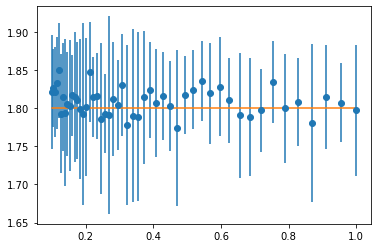

In [5]:
xGrid = np.logspace(-1,-0.0000000001,50)
theoryParams = [1.8]
stats = np.array([ 0.01 for i in range(len(xGrid))])#np.random.normal(0.009, 0.008)
normErr = 0.0
normFluct = 0.0 # r=1+0.1*0.7 = 1.07
#syst1= abs(np.array([0.34, 0.30, 0.42, 0.69,0.54, 0.20, 0.25, 0.12, -0.4, -0.12, 0.56, 0.53, 0.34,0.25,  0.45, 0.23, 0.31, 0.23, 0.42, -0.31])) #this is the original systematic error 
syst1 = [0.05 for i in range(len(xGrid))]
syst2 = [np.random.normal(0.03, 0.04) for i in range(len(xGrid))]
systFluct =[0.4, -0.3]
seed=0
dataGen = DatasetGenerator(theoryParams, theory, xGrid, stats, normErr, normFluct, systFluct, seed, syst1, syst2)#, syst2)

Parameter at minimum :  [1.82297116]
Chisqr at minimum :  62.442588178802424
Chisqr per dof :  1.2743385342612739
Number of Function Calls :  82
Parameter error using hessian method : 
 [0.0500448]
Mean parAtmin : 
 [1.82651484]
std parAtmin : 
 [0.05171036]
updated hessian error : 
Mean funAtmin : 
 109.67455641623258
std funAtmin : 
 19.511452212865517


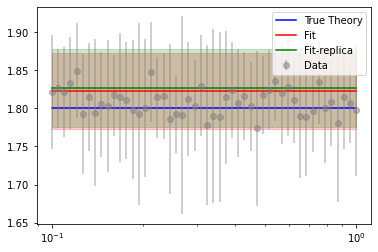

In [6]:
chi2 = ChiSquareCorr(dataGen, theory)
globalanalysis = GlobalAnalysis(1, chi2)
bound = [1.0]
globalanalysis.runFit(bound, False)



---
# Fitting Polynomial Curve
---
## Data

In [8]:
def theory (x, params):
    return (np.sin(params[0]*x+ x**(params[1]))+ np.sinh(params[2]*x+x**(params[3])))
def theory1 (x, params):
    return params[0] + params[1]*x +params[2]*x**2
def theory2 (x, params):
    return params[0] + params[1]*x +params[2]*x**2 + params[3]*x**3 +params[4]*x**4
def theory3 (x, params):
    return params[0] + params[1]*x +params[2]*x**2 + params[3]*x**3 +params[4]*x**4 + params[5]*x**5 +params[6]*x**6 



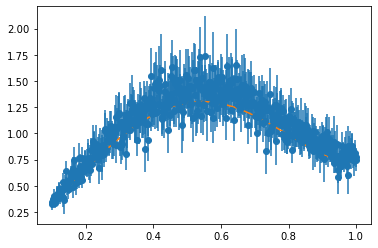

In [9]:
#xGrid = np.logspace(-1,-0.0001,50)
xGrid = np.linspace(0.1, 1.0, 500)
theoryParams = [2.8, 1.6, 0.1, 2]
theo = [theory(x, theoryParams) for x in xGrid]
stats =[np.random.normal(0.03, 0.02)*t for t in theo]
syst1 = [np.random.normal(0.01, 0.01)*t for t in theo]
syst2 = [np.random.normal(0.03, 0.07)*t for t in theo]
syst3 = [np.random.normal(-0.05, 0.01) *t for t in theo]
syst4 = [np.random.normal(-0.04, 0.08) *t for t in theo]
syst5 = [np.random.normal(-0.02, 0.06) *t for t in theo]
syst6 = [np.random.normal(0.01, 0.04) *t for t in theo]
syst7 = [np.random.normal(0.04, 0.06) *t for t in theo]
systFluct =[0.8, 0.7, -0.1, -0.2, -1.1, 1.0, 0.3]
normErr = 0.0
normFluct = 0.0
dataGen = DatasetGenerator(theoryParams, theory, xGrid, stats, normErr, normFluct, systFluct, 0, syst1, syst2, syst3, syst4, syst5, syst6, syst7)
                           #, syst1, syst2, syst3, syst4, syst5, syst6, syst7)

### True Theory

Parameter at minimum :  [2.79340697 1.58191883 0.09585672 1.97906042]
Chisqr at minimum :  480.94392995623497
Chisqr per dof :  0.9696450200730544
Number of Function Calls :  821
Parameter error using hessian method : 
 [0.00752096 0.01487113 0.00531101 0.01123306]
Mean parAtmin : 
 [2.79993628 1.59962692 0.09994757 1.99933315]
std parAtmin : 
 [0.0077052  0.01580033 0.00542525 0.01121051]
updated hessian error : 
Mean funAtmin : 
 493.34707395183216
std funAtmin : 
 30.458071589125744


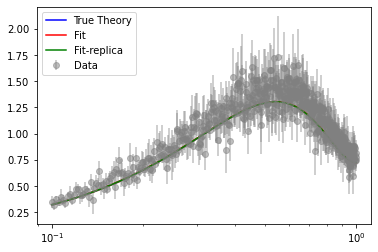

In [10]:
bound = [0.1, 0.1, 0.1, 0.1]
chi2_ignorm = ChiSquareCorr(dataGen, theory)
globalanalysis_ignorm = GlobalAnalysis(1, chi2_ignorm)
globalanalysis_ignorm.runFit(bound, True)

Parameter at minimum :  [-0.11269902  4.36471002 -3.8624364 ]
Chisqr at minimum :  14250.950155953531
Chisqr per dof :  28.67394397576163
Number of Function Calls :  384
Parameter error using hessian method : 
 [0.00125671 0.00866275 0.00806348]
Mean parAtmin : 
 [-0.11365352  4.36086613 -3.85909592]
std parAtmin : 
 [0.00116004 0.00815433 0.00764615]
updated hessian error : 
Mean funAtmin : 
 14414.927808002169
std funAtmin : 
 235.83324096728794


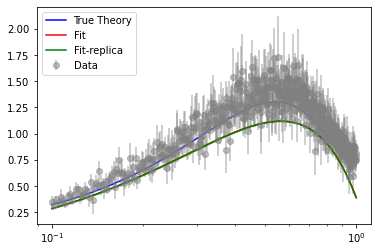

In [12]:
bound = [0.1, 0.1, 0.1]
#bound = [0.1, 0.1, 0.1, 0.1, 0.1]
#bound = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
chi2_ignorm = ChiSquareCorr(dataGen, theory1)
globalanalysis_ignorm = GlobalAnalysis(1, chi2_ignorm)
globalanalysis_ignorm.runFit(bound, True)

Parameter at minimum :  [  0.07477565   1.89029714   8.69303354 -20.40760262  10.46820484]
Chisqr at minimum :  528.5847758720241
Chisqr per dof :  1.0678480320646953
Number of Function Calls :  1190
Parameter error using hessian method : 
 [0.00453826 0.04788231 0.17652114 0.25067399 0.118942  ]
Mean parAtmin : 
 [  0.07262697   1.89654961   8.67922051 -20.40402786  10.47437387]
std parAtmin : 
 [0.00421222 0.04505491 0.16953437 0.2449349  0.1175977 ]
updated hessian error : 
Mean funAtmin : 
 568.4688816253838
std funAtmin : 
 35.055462094619934


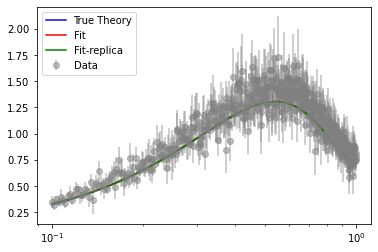

In [11]:
#bound = [0.1, 0.1, 0.1]
bound = [0.1, 0.1, 0.1, 0.1, 0.1]
#bound = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
chi2_ignorm = ChiSquareCorr(dataGen, theory2)
globalanalysis_ignorm = GlobalAnalysis(1, chi2_ignorm)
globalanalysis_ignorm.runFit(bound, True)

Parameter at minimum :  [  0.07477589   1.89029262   8.69305889 -20.407645    10.46822677
  -0.03653368   0.02896458]
Chisqr at minimum :  528.5847757956698
Chisqr per dof :  1.0721800726078494
Number of Function Calls :  1332
Parameter error using hessian method : 
 [1.64265427e-03 1.09794276e-02 2.21794191e-09 3.09476995e-02
 2.38528390e-02 1.34464966e+14 1.06607102e+14]
Mean parAtmin : 
 [  0.073079     1.89240744   8.6901433  -20.41557994  10.47861729
  -0.03653368   0.02896458]
std parAtmin : 
 [4.54554841e-03 4.79460070e-02 1.72843262e-01 2.44047015e-01
 1.15704914e-01 1.11300903e-16 1.11300903e-16]
updated hessian error : 
Mean funAtmin : 
 568.3791698981471
std funAtmin : 
 36.69068780444253


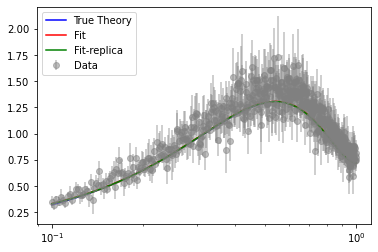

In [13]:
#bound = [0.1, 0.1, 0.1]
#bound = [0.1, 0.1, 0.1, 0.1, 0.1]
bound = [ 0.04922885  , 2.10736014,   8.07308425, -19.76340502,  10.2543998, 0.0, 0.0]
chi2_ignorm = ChiSquareCorr(dataGen, theory2)
globalanalysis_ignorm = GlobalAnalysis(1, chi2_ignorm)
globalanalysis_ignorm.runFit(bound, True)

---
# Global Analysis
---


In [38]:
def theory (x, params):
    return params[0] + params[1]*x + params[2]* x**4 + params[3] * x**7
def theoryFit (x, params) : 
    return params[0] + params[1]*x + params[2]* x**2 + params[3] * x**3

Real statistical error :  [ 0.17640523  0.04001572  0.0978738   0.22408932  0.1867558  -0.09772779
  0.09500884 -0.01513572 -0.01032189  0.04105985  0.01440436  0.14542735
  0.07610377  0.0121675   0.04438632  0.03336743  0.14940791 -0.02051583
  0.03130677 -0.08540957 -0.25529898  0.06536186  0.08644362 -0.0742165
  0.22697546 -0.14543657  0.00457585 -0.01871839  0.15327792  0.14693588
  0.01549474  0.03781625 -0.08877857 -0.19807965 -0.03479121  0.0156349
  0.12302907  0.12023798 -0.03873268 -0.03023028 -0.1048553  -0.14200179
 -0.17062702  0.19507754 -0.05096522 -0.04380743 -0.12527954  0.07774904
 -0.16138978 -0.02127403]
Real systematic error :  [[ 0.15119041  0.41321309  0.35248638  0.4160774   0.60882869  0.36824918
   0.59304922  0.54297591  0.71917908  0.5163954   0.52061373  0.59637945
   0.42276291 -0.0222619   0.71123679  0.38313729  0.12922174  0.58984417
   0.19313365  0.32991406  0.31429261  0.17007567  0.6718867   0.22469514
   0.32909601  0.28634325 -0.04449239  0.3295

,x,data,theory,stats,syst_0
0,0.100000,3.287855,2.960260,0.1,0.215986
1,0.104811,3.421240,2.968011,0.1,0.590304
2,0.109854,3.426505,2.976144,0.1,0.503552
3,0.115140,3.624846,2.984679,0.1,0.594396
4,0.120679,3.789221,2.993637,0.1,0.869755
5,0.126486,3.273561,3.003040,0.1,0.526070
6,0.132571,3.700972,3.012914,0.1,0.847213
7,0.138950,3.551124,3.023284,0.1,0.775680
8,0.145635,3.743036,3.034179,0.1,1.027399
9,0.152642,3.603085,3.045629,0.1,0.737708


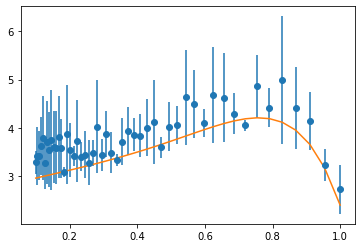

In [40]:
xGrid = np.logspace(-1,-0.0000000001,50)
theoryParams = [2.8, 1.6, 2.6, -4.6  ]
stats = np.array([0.1 for i in range(len(xGrid))])
syst1 = [np.random.normal(0.5, 0.3) for i in range(len(xGrid))]
#syst2 = [np.random.normal(0.3, 0.4) for i in range(len(xGrid))]
systFluct = [0.7]
dataGen = DatasetGenerator(theoryParams, theory, xGrid, stats, 0.02 , 0.0 , systFluct, 0, syst1)

Parameter at minimum :  [ 2.86132868  1.38315934  2.71630895 -4.64087267]
Chisqr at minimum :  54.92621830990463
Chisqr per dof :  1.1940482241283614
Number of Function Calls :  2090
Parameter error using hessian method : 
 [0.05555033 0.17159727 0.51065744 0.44316332]


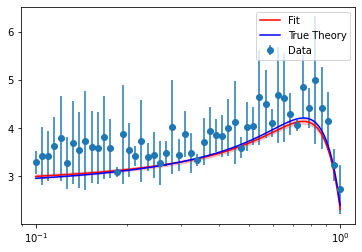

Mean parAtmin : 
 [ 2.79354987  1.60998089  2.54926764 -4.5478722 ]
std parAtmin : 
 [0.06987177 0.17066889 0.52513201 0.45975082]
Mean funAtmin : 
 45.45622687510253
std funAtmin : 
 10.090565780467507
Mean z : 
 [ 0.11190614  0.07850959 -0.06572908  0.10636688]
std z : 
 [2.14398219 1.01728119 0.94649325 1.0314824 ]


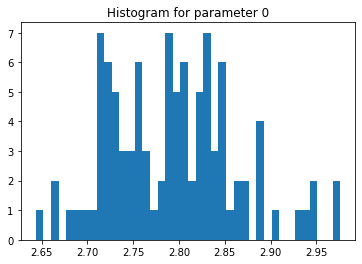

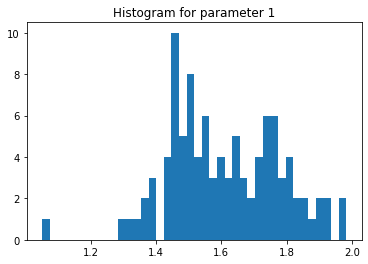

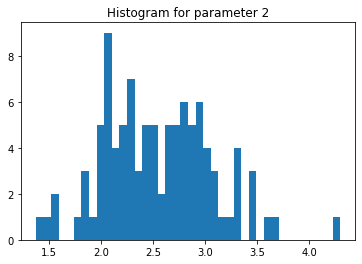

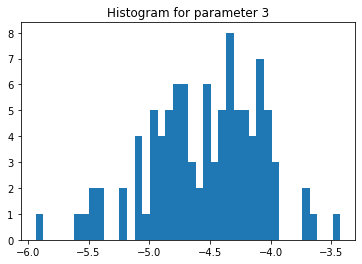

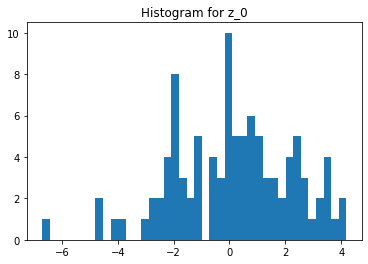

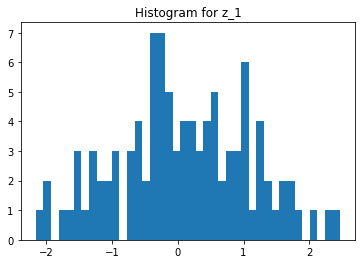

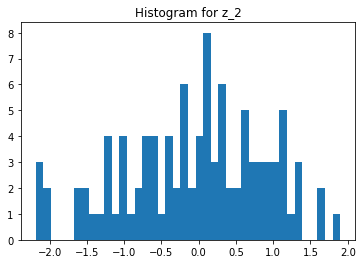

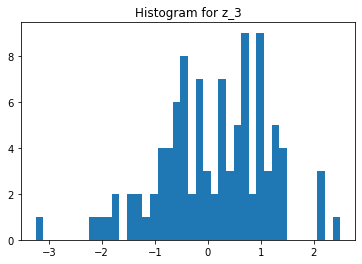

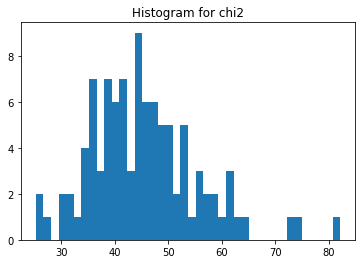

In [44]:
chi2 = ChiSquareCorr(dataGen, theory)
globalanalysis = GlobalAnalysis(1, chi2)
bound = [(-5,5), (-5,5), (-5,5), (-10,10)]
globalanalysis.runFit(bound)
globalanalysis.runReplicaFits(bound, 100, True)
#theoryParams = [2.8, 1.6, 2.6, -4.6  ]

Parameter at minimum :  [  3.43239136  -4.93037841  18.39953382 -14.27832737]
Chisqr at minimum :  86.25495034228312
Chisqr per dof :  1.8751076161365896
Number of Function Calls :  3490
Parameter error using hessian method : 
 [0.10105875 0.73759355 1.62312359 1.02856262]


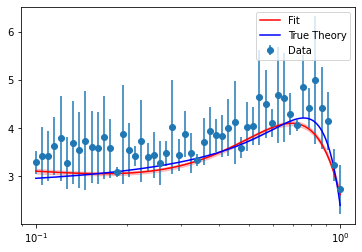

In [42]:
chi2 = ChiSquareCorr(dataGen, theoryFit)
globalanalysis = GlobalAnalysis(1, chi2)
bound = [(-20,20), (-20,20), (-100,100), (-20,20)]
globalanalysis.runFit(bound)
#theoryParams = [2.8, 1.6, 2.6, -4.6  ]

Parameter at minimum :  [  3.43242332  -4.93051823  18.39953868 -14.2781905 ]
Chisqr at minimum :  86.2549513328431
Chisqr per dof :  1.8751076376705023
Number of Function Calls :  3115
Parameter error using hessian method : 
 [0.10105875 0.73759355 1.62312359 1.02856262]


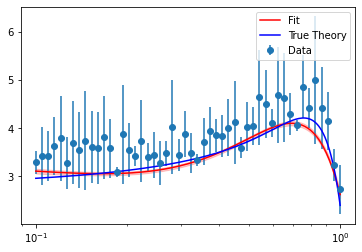

Mean parAtmin : 
 [  3.30858503  -4.26225974  17.38123515 -13.71006692]
std parAtmin : 
 [0.11773533 0.68918224 1.57212822 1.01316751]
Mean funAtmin : 
 86.25842178928725
std funAtmin : 
 17.004417692421452
Mean z : 
 [ 5.95583037 -9.24355475 -1.5569216  -8.93482783]
std z : 
 [6.78891725 9.33273471 1.87397223 0.96917379]


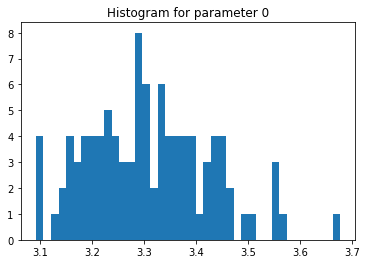

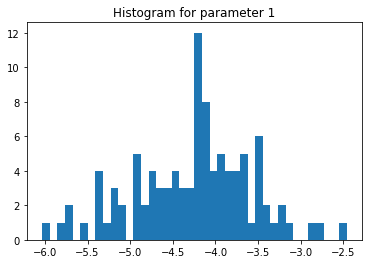

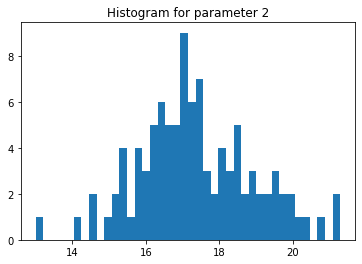

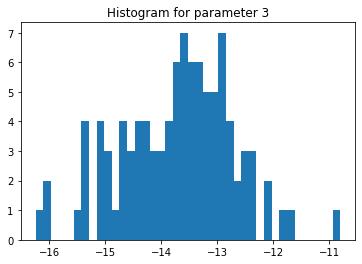

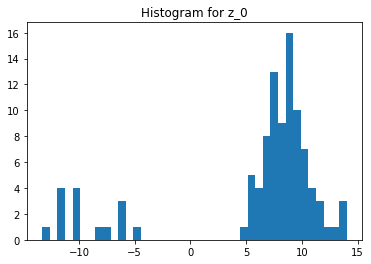

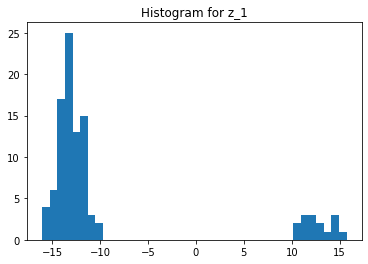

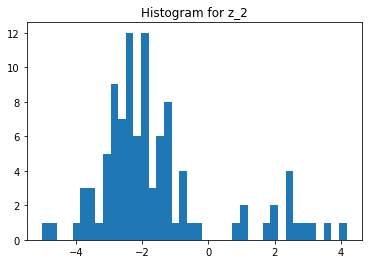

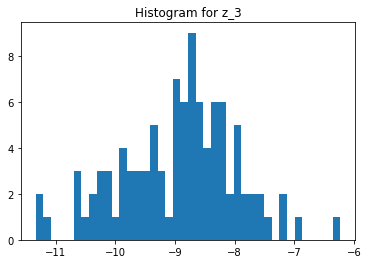

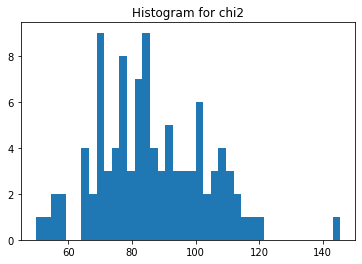

In [48]:
chi2corrfit =ChiSquareCorr(dataGen, theoryFit, 4)
globalAnalysisCorrFit= GlobalAnalysis(1, chi2corrfit)
bound = [(-5,5), (-5,5), (-20,20), (-20,20)]
globalAnalysisCorrFit.runFit(bound)
globalAnalysisCorrFit.runReplicaFits(bound, 100, True)
#theoryParams =[2.8, 1.6, 2.6, -4.6, 0.7, 0.6  ]

---
# Global Analysis
---

In [18]:
def theory1 (x, params):
    return (np.sin(params[0]*x+ x**(params[1]))+ np.sinh(params[2]*x+x**(params[3])))
def theory2 (x, params) : 
    return (np.sin(params[0]*x+ x**(params[1]))+ np.sinh(params[2]*x+x**(params[3])))
def theory3 (x, params) : 
    return (np.sin(params[0]*x+ x**(params[1]))+ np.sinh(params[2]*x+x**(params[3])))

theoryParams1 = [2.3, 1.4, 0.1, 2  ]
theoryParams2 = [2.6, 1.6, 0.15, 2.1  ]
theoryParams3 = [2.9, 1.3, 0.12, 2.3]

,x,data,theory,stats,syst_0,syst_1
0,0.100000,0.291684,0.286550,0.011217,-0.015945,-0.004364
1,0.104320,0.289945,0.299761,0.011817,-0.007177,-0.011902
2,0.108827,0.287162,0.313579,0.014445,-0.010350,-0.041637
3,0.113528,0.352620,0.328029,0.011368,-0.017754,0.014432
4,0.118432,0.386796,0.343137,0.009423,0.005768,0.027531
5,0.123548,0.328224,0.358929,0.016144,0.007382,-0.025118
6,0.128886,0.428583,0.375433,0.013857,0.021501,0.031168
7,0.134453,0.396496,0.392676,0.013513,-0.020175,0.024984
8,0.140262,0.445453,0.410685,0.008160,0.005918,0.039334
9,0.146321,0.413505,0.429488,0.012140,0.013326,-0.037870


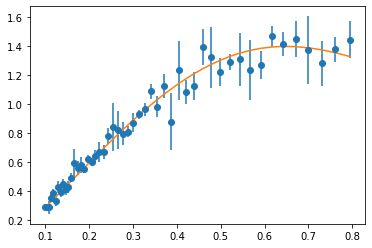

In [19]:
xGrid_1 =  np.logspace(-1,-0.1, 50)
theo = [theory1(x, theoryParams1) for x in xGrid_1]
stats_1 = np.array([np.random.normal(0.03, 0.01)*t for t in theo])
syst1_1 = [np.random.normal(-0.01, 0.05)*t for t in theo]
syst2_1 = [np.random.normal(0.01, 0.1)*t for t in theo]
systFluct_1 = [0.7, 0.8]
normErr1 = 0.0
normFluct1 = 0.0
dataGen_1 = DatasetGenerator(theoryParams1, theory1, xGrid_1, stats_1, normErr1, normFluct1, systFluct_1,0, syst1_1, syst2_1)

,x,data,theory,stats,syst_0,syst_1,syst_2
0,0.316228,0.589165,0.967861,-0.240649,0.006286,0.045751,0.005065
1,0.323746,1.102649,0.987533,0.134374,-0.089305,0.117056,0.010295
2,0.331442,0.925163,1.007269,-0.134210,-0.088755,0.020357,0.064452
3,0.339322,0.318037,1.027038,-0.343226,-0.021484,0.017401,0.047460
4,0.347389,1.120644,1.046802,0.012086,-0.089181,0.048218,0.047740
5,0.355648,0.879009,1.066521,0.158378,0.008861,0.025022,-0.047650
6,0.364103,1.200893,1.086150,0.043397,-0.067785,0.103255,0.020666
7,0.372759,1.040458,1.105643,0.122441,-0.080075,0.007521,-0.010527
8,0.381621,1.194851,1.124948,-0.191575,0.008649,0.004614,0.035095
9,0.390694,1.150890,1.144008,-0.101613,-0.006389,0.037166,0.018389


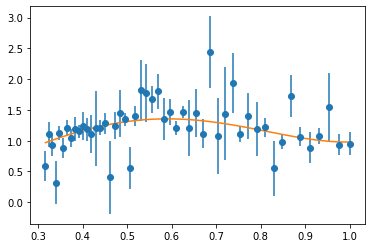

In [20]:
xGrid_2 = np.logspace(-0.5,-0.0000000001,50)
theo = [theory2(x, theoryParams2) for x in xGrid_2]
stats_2= np.array([np.random.normal(0.02, 0.3)*t for t in theo])
syst1_2 = [np.random.normal(-0.05, 0.030)*t for t in theo]
syst2_2 = [np.random.normal(0.05, 0.040)*t for t in theo]
syst3_2 = [np.random.normal(0.02, 0.04)*t for t in theo]
systFluct_2 = [0.5, 0.8, 1.2]
normErr2 = 0.0
normFluct2 = 0.0
dataGen_2 = DatasetGenerator(theoryParams2, theory1, xGrid_2, stats_2, normErr2, normFluct2, systFluct_2,0, syst1_2, syst2_2, syst3_2)

,x,data,theory,stats
0,0.100000,0.406923,0.350612,0.031922
1,0.115254,0.421979,0.405139,0.042081
2,0.130508,0.501920,0.459266,0.043581
3,0.145763,0.614142,0.512797,0.045225
4,0.161017,0.670865,0.565544,0.056395
5,0.176271,0.554408,0.617322,0.064376
6,0.191525,0.731836,0.667953,0.067240
7,0.206780,0.706076,0.717261,0.073896
8,0.222034,0.757681,0.765077,0.071655
9,0.237288,0.843339,0.811238,0.078181


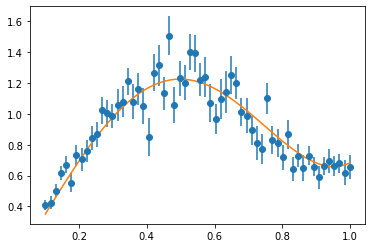

In [21]:
xGrid_3 = np.linspace(0.1, 1, 60)
theo = [theory3(x, theoryParams3) for x in xGrid_3]
stats_3= np.array([np.random.normal(0.1, .01)*t for t in theo])
#syst1_3 = [np.random.normal(-0.05, 0.15) for i in range(len(xGrid_2))]
#syst2_2 = [np.random.normal(0.15, 0.2) for i in range(len(xGrid_2))]
#syst3_2 = [np.random.normal(0.2, 0.1) for i in range(len(xGrid_2))]
systFluct_3= []
normErr3 = 0.0
normFluct3 = 0.78
dataGen_3 = DatasetGenerator(theoryParams3, theory1, xGrid_3, stats_3, normErr3, normFluct3, systFluct_3, 0)

Parameter at minimum :  [   2.22545554    1.50936923   -0.37722409    1.10303246  -63.18873985
 -226.14087681   -0.35155672   76.66346463]
Chisqr at minimum :  563.6269142910807
Chisqr per dof :  3.61299304032744
Number of Function Calls :  2769
Parameter error using hessian method : 
 [2.05115942e-02 7.33506477e-02 7.38889176e-10 2.18489338e-02]
Mean parAtmin : 
 [ 2.59655833e+00  2.10187368e+00 -5.50289686e-02  1.70537051e+00
 -6.31887399e+01 -2.26140877e+02 -3.51556719e-01  7.66634646e+01]
std parAtmin : 
 [2.06132799e-01 3.49550999e-01 1.61934380e-01 3.32830800e-01
 1.21095383e-13 7.69311844e-13 8.34756776e-16 2.27944250e-13]
updated hessian error : 
Mean funAtmin : 
 504.21497559451984
std funAtmin : 
 42.430641054397775


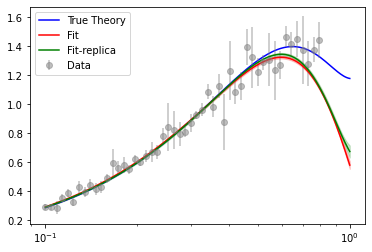

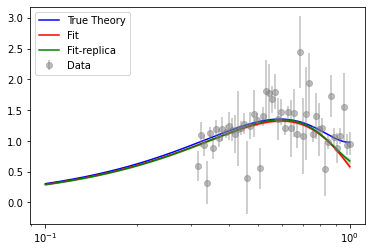

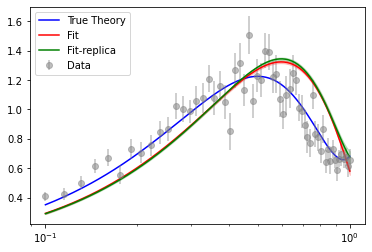

In [22]:
chi1 = ChiSquareCorr(dataGen_1, theory1)
chi2 = ChiSquareCorr(dataGen_2, theory1)
chi3 = ChiSquareCorr(dataGen_3, theory1)
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [(0,5), (0, 5), (-5, 5), (0, 5)]
globalAnalysis.runFit(bound)
#globalAnalysis.getParameterError()
#[2.8, 1.6, 2.6, -4.6  ]

In [ ]:
chi1 = ChiSquareCorr(dataGen_1, theory1)
chi2 =ChiSquareCorr(dataGen_2, theory2)
chi3 = ChiSquareCorr(dataGen_3, theory3)
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [(-10,10), (-10,10), (-10,10), (-10,10)]
globalAnalysis.runFit(bound)
#globalAnalysis.getParameterError()
#[2.8, 1.6, 2.6, -4.6  ]

In [ ]:
chi1 = ChiSquareDAgostini(dataGen_1, theory1)
chi2 =  ChiSquareDAgostini(dataGen_2, theory2)
chi3 = ChiSquareCorr(dataGen_3, theory3)
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [2.8, 1.6, 2.6, -4.6 , 1.02, 0.95 ]# [(-10,10), (-10,10), (-10,10), (-10,10), (0,2), (0,2)]
globalAnalysis.runFit(bound)
#globalAnalysis.getParameterError()
#[2.8, 1.6, 2.6, -4.6  ]

In [ ]:
print ("--------------------------------------------" )
print("New method to fit noralization errror analytic ")
chi1 = ChiSquareNewNormFitAnalytic(dataGen_1, theory1)
chi2 =  ChiSquareNewNormFitAnalytic(dataGen_2, theory2)
chi3 = ChiSquareCorr(dataGen_3, theory3)
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [2.8, 1.6, 2.6, -4.6  ]# [(-10,10), (-10,10), (-10,10), (-10,10)]
globalAnalysis.runFit(bound)

In [ ]:
chi1 = ChiSquareNewNormFit(dataGen_1, theory1)
chi2 =  ChiSquareNewNormFit(dataGen_2, theory2)
chi3 = ChiSquareCorr(dataGen_3, theory3)
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [(-10,10), (-10,10), (-10,10), (-10,10), (0,2), (0,2)]
globalAnalysis.runFit(bound)
#globalAnalysis.getParameterError()
#[2.8, 1.6, 2.6, -4.6  ]

In [ ]:
chi1 = ChiSquareNormFittedTheo(dataGen_1, theory1)
chi2 =  ChiSquareNormFittedTheo(dataGen_2, theory2)
chi3 = ChiSquareCorr(dataGen_3, theory3)
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [(-10,10), (-10,10), (-10,10), (-10,10)]
globalAnalysis.runFit(bound)
#globalAnalysis.getParameterError()
#[2.8, 1.6, 2.6, -4.6  ]

### Tensions

In [4]:
def theory1 (x, params):
    return (params[0]*x**5 + params[1]*x**6 - params[2]*x**3- params[3] * x**8)
def theory2 (x, params) : 
    return theory1(x, params)#(params[0]*params[1])*x + (params[2]*params[3])* x**2 
def theory3 (x, params) : 
    return theory1(x, params)#(params[0]**2+params[1]**2+params[2]**2+params[3]**2) * x**2

theoryParams1 = [1.5, 0.9, 1.7, -5.3  ]
theoryParams2 = [1.8, 0.7, 1.9, -5.9 ]
theoryParams3 = [1.9, 0.5, 1.8, -5.5 ]

Real statistical error :  [-0.00453138  0.00219206 -0.0171457   0.0308823  -0.05165907  0.00068671
 -0.04951378 -0.03087769  0.01426616 -0.01339747 -0.01913699  0.00098246
 -0.01482229 -0.02437125  0.01105259 -0.02356951 -0.03337248 -0.03663496
  0.01200571  0.0169529  -0.01134339  0.00291716 -0.00061231 -0.01898907
  0.00386291  0.01466706 -0.00952045 -0.0357626   0.01185451  0.01224026
  0.01949925 -0.00239313  0.01071881  0.00151364 -0.0088966  -0.01256036
 -0.02279804 -0.02246083 -0.00257489  0.0006955  -0.00278648 -0.00382637
 -0.02848948 -0.02069135 -0.04044115  0.01626394 -0.0058648   0.03993559
  0.00228589  0.00872074]
Real systematic error :  [[-2.47366091e-02 -1.00803645e-02 -6.23626259e-03  9.03463992e-04
  -3.41888758e-02  2.50654985e-02  1.87996295e-02  8.99856079e-05
  -5.97519800e-03 -1.41662735e-02 -7.51292006e-02  2.18304906e-02
   5.80503603e-02 -3.38248407e-02 -1.55094108e-02 -1.01748118e-01
  -1.27189864e-02 -3.50268008e-03 -2.43272472e-03 -3.10082595e-02
  -4.1029

,x,data,theory,stats,syst_0,syst_1
0,0.100000,-0.010001,-0.001684,0.030108,-0.035338,0.025889
1,0.104320,0.040384,-0.001910,0.017736,-0.014401,0.063940
2,0.108827,-0.030348,-0.002167,0.016422,-0.008909,-0.006910
3,0.113528,0.005018,-0.002457,0.024375,0.001291,-0.030238
4,0.118432,-0.069003,-0.002786,0.025417,-0.048841,0.022470
5,0.123548,0.059434,-0.003159,0.015557,0.035808,0.047835
6,0.128886,-0.028118,-0.003582,0.024756,0.026857,0.006879
7,0.134453,-0.003084,-0.004060,0.024885,0.000129,0.039612
8,0.140262,0.028252,-0.004602,0.012611,-0.008536,0.031551
9,0.146321,0.002740,-0.005215,0.013316,-0.020238,0.044481


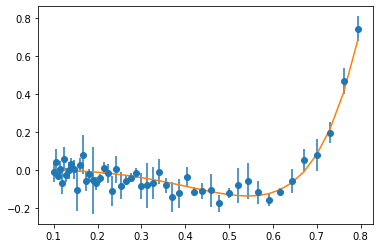

In [5]:
xGrid_1 =  np.logspace(-1,-0.1,50)
stats_1 = np.array([np.random.normal(0.02, 0.004) for i in range(len(xGrid_1))])
syst1_1 = [np.random.normal(-0.01, 0.05) for i in range(len(xGrid_1))]
syst2_1 = [np.random.normal(0.01, 0.03) for i in range(len(xGrid_1))]
systFluct_1 = [0.7, 0.8]
normErr1 = 0.03
normFluct1 = 0.8
dataGen_1 = DatasetGenerator(theoryParams1, theory1, xGrid_1, stats_1, normErr1, normFluct1, systFluct_1, syst1_1, syst2_1)

Real statistical error :  [-0.09738142  0.03288263 -0.31190922  0.72876724  0.42857443  0.1991053
  0.21866726 -0.16465407 -0.25666278 -0.23030593  0.03979918 -0.73823436
 -0.00874989  0.1368335  -0.08873183 -0.24352385 -0.05310079  0.08781598
 -0.19837316 -0.11990295 -0.00366597 -0.00898929 -0.02641993  0.48382752
 -0.04289635 -0.00382238 -0.05990374  0.03066766 -0.03145641 -0.0773476 ]
Real systematic error :  [[-0.01402776  0.01700481 -0.00834999 -0.01022657  0.01360814 -0.03469014
   0.02227663 -0.00538201  0.01377622 -0.01606072  0.01298829  0.0233038
  -0.03758595 -0.00259905 -0.00560899 -0.00330919 -0.00079231  0.01675913
  -0.03278384  0.00969266  0.0092116   0.00725962  0.01356693  0.00125535
  -0.00732411  0.00855235  0.00365262 -0.02908313  0.00280217  0.01496748]
 [ 0.00682146  0.00714082  0.01448505  0.00017064  0.00671456  0.0422179
   0.07198329 -0.01979299  0.06516913  0.00072437  0.01732288 -0.00717266
   0.02343642  0.00403307  0.00915102  0.02038874  0.01359267  0.03

,x,data,theory,stats,syst_0,syst_1,syst_2
0,0.316228,-0.199444,-0.053101,0.241638,-0.028056,0.008527,-0.030682
1,0.329034,-0.007407,-0.059042,0.043406,0.034010,0.008926,-0.004342
2,0.342360,-0.364648,-0.065536,-0.348199,-0.016700,0.018106,0.013073
3,0.356225,0.615324,-0.072601,-0.633184,-0.020453,0.000213,-0.038346
4,0.370651,0.366164,-0.080241,0.257467,0.027216,0.008393,-0.009629
5,0.385662,0.152542,-0.088439,0.193842,-0.069380,0.052772,0.025478
6,0.401281,0.196042,-0.097153,-0.139874,0.044553,0.089979,-0.020486
7,0.417532,-0.229107,-0.106300,0.135979,-0.010764,-0.024741,0.060578
8,0.434441,-0.291251,-0.115743,-0.136212,0.027552,0.081461,0.007848
9,0.452035,-0.419479,-0.125267,-0.441524,-0.032121,0.000905,-0.031823


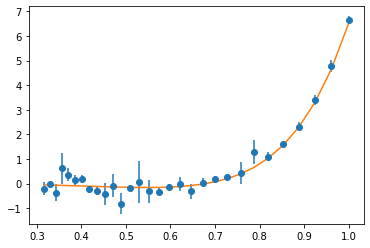

In [6]:
xGrid_2 = np.logspace(-0.5,-0.0000000001,30)
stats_2= np.array([np.random.normal(0.02, 0.3) for i in range(len(xGrid_2))])
syst1_2 = [np.random.normal(-0.005, 0.030) for i in range(len(xGrid_2))]
syst2_2 = [np.random.normal(0.015, 0.040) for i in range(len(xGrid_2))]
syst3_2 = [np.random.normal(0.02, 0.04) for i in range(len(xGrid_2))]
systFluct_2 = [0.5, 0.8, 1.2]
normErr2 = 0.025
normFluct2 = -0.99
dataGen_2 = DatasetGenerator(theoryParams2, theory2, xGrid_2, stats_2, normErr2, normFluct2, systFluct_2, syst1_2, syst2_2, syst3_2)

Real statistical error :  [ 0.11756671  0.19916252  0.03220226 -0.09776804  0.04777698 -0.38509525
  0.31311636 -2.20006299  1.08622662 -0.26651984 -0.25094268  0.61494433
 -4.66821415 -2.90321756  1.70217411  0.24650962  1.28535677 -5.737466
 -2.63029478 -0.16997797  1.15916106 -1.32535439 -0.45686547  0.68802733
 -0.62854789 -3.25669977  0.03075716 -1.81866842  1.6536841   2.2500132
  0.08871975 -0.45876875 -3.51153555 -2.71977897 -3.35966516  0.21952241
  0.32603755  0.66471894  1.36504106  2.05809629]
Real systematic error :  []


,x,data,theory,stats
0,0.000000,0.116403,0.000000,2.358452
1,0.025641,0.197161,-0.000030,-0.559388
2,0.051282,0.031644,-0.000242,1.286750
3,0.076923,-0.097606,-0.000814,0.644232
4,0.102564,0.045403,-0.001920,0.381294
5,0.128205,-0.384970,-0.003725,2.640748
6,0.153846,0.303697,-0.006382,1.314598
7,0.179487,-2.188212,-0.010032,1.747416
8,0.205128,1.060827,-0.014792,1.056814
9,0.230769,-0.284433,-0.020758,0.290220


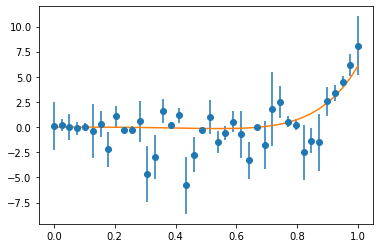

In [7]:
xGrid_3 = np.linspace(0, 1, 40)
stats_3= np.array([np.random.normal(1.5, 1.0) for i in range(len(xGrid_3))])
#syst1_3 = [np.random.normal(-0.05, 0.15) for i in range(len(xGrid_2))]
#syst2_2 = [np.random.normal(0.15, 0.2) for i in range(len(xGrid_2))]
#syst3_2 = [np.random.normal(0.2, 0.1) for i in range(len(xGrid_2))]
systFluct_3= []
normErr3 = 0.05
normFluct3 = 0.2
dataGen_3 = DatasetGenerator(theoryParams3, theory3, xGrid_3, stats_3, normErr3, normFluct3, systFluct_3)

Parameter at minimum :  [ 0.20119611  2.50561316  1.64858073 -5.45419862]
Chisqr at minimum :  107.28368895426351
Chisqr per dof :  0.9248593875367545
Number of Function Calls :  1780
Parameter error using hessian method : 
 [3.49802315 5.02420067 0.3254161  1.97759592]


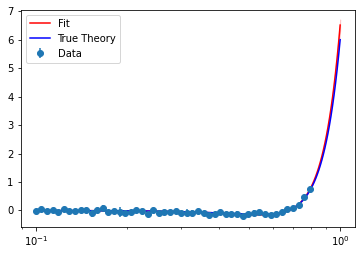

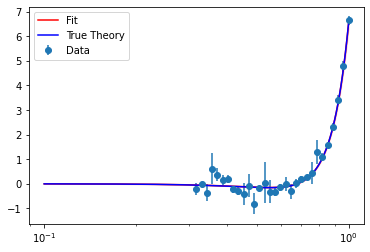

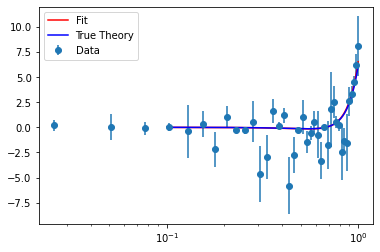

Mean parAtmin : 
 [ 2.82005736 -2.01730947  1.72121057 -7.42955898]
std parAtmin : 
 [3.2805084  4.77525505 0.2963035  1.93826856]
Mean funAtmin : 
 120.43932374529847
std funAtmin : 
 15.373321596434838
Mean z : 
 [ 1.30741571  3.16643513  2.6413252  -0.57519912]
std z : 
 [1.44252535 3.04649369 1.96541721 0.99662007]


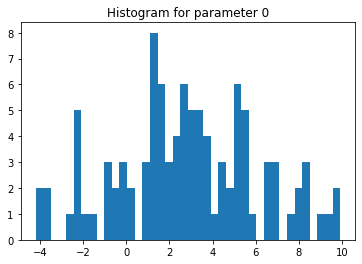

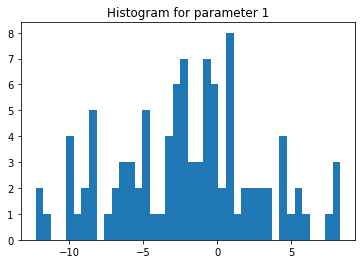

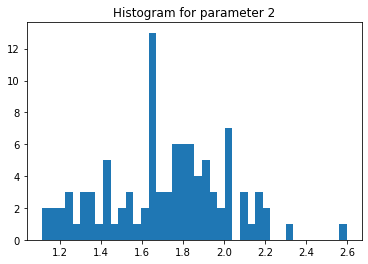

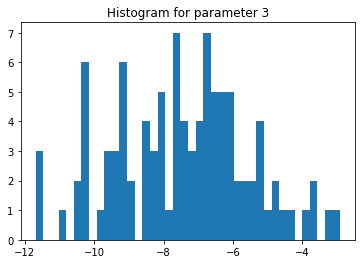

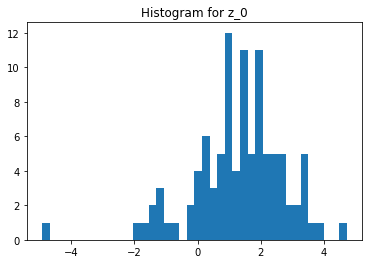

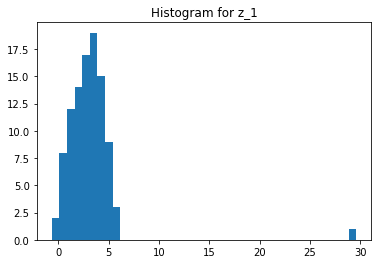

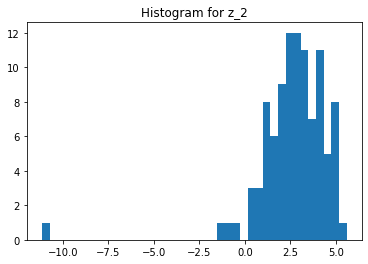

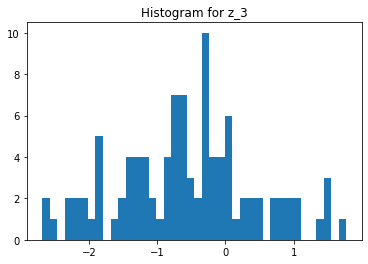

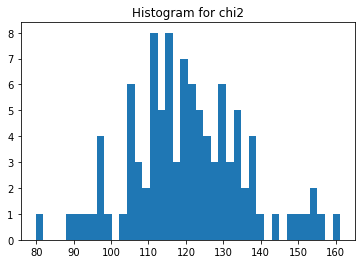

In [10]:
                     
chi1 =ChiSquareTmethod(dataGen_1, theory1)
chi2 =ChiSquareTmethod(dataGen_2, theory2)
chi3 = ChiSquareTmethod(dataGen_3, theory3)
                     
                     
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [(0,5), (0,3), (0,5), (-7,-3)]
boundg =[(-10,10), (-10,10), (-10,10), (-10,10)]
globalAnalysis.runFit(bound, False)
globalAnalysis.runReplicaFits(bound, 100)


In [17]:
chi1 =ChiSquareTmethod(dataGen_1, theory1)
chi2 =ChiSquareTmethod(dataGen_2, theory2)
chi3 = ChiSquareTmethod(dataGen_3, theory3)
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [(0,5), (0,3), (0,5), (-7,-3)]
boundg =[(-10,10), (-10,10), (-10,10), (-10,10)]
globalAnalysis.runFit(bound, False)
globalAnalysis.runReplicaFits(bound, 100, False)

ZeroDivisionError: float division by zero

# Linear theory

In [7]:
def theory1 (x, params):
    return (params[0]+ params[1]*x)
def theory2 (x, params) : 
    return theory1(x, params)#(params[0]*params[1])*x + (params[2]*params[3])* x**2 
def theory3 (x, params) : 
    return theory1(x, params)#(params[0]**2+params[1]**2+params[2]**2+params[3]**2) * x**2

theoryParams1 = [1.5, 0.9]
theoryParams2 = [1.8, 0.7]
theoryParams3 = [1.9, 0.5]

Real statistical error :  [ 0.00764717 -0.0097977  -0.03017143 -0.03777079 -0.02254946 -0.00081635
  0.00313614 -0.00726204  0.00255539 -0.00753435  0.01048435 -0.00373445
 -0.0110513   0.00161136  0.00878731 -0.02981013 -0.01307226  0.00687812
 -0.00719447  0.00609514  0.01916042 -0.00669023 -0.01179484  0.03155968
  0.01766734  0.02100527  0.0008719   0.00080584  0.00556131 -0.02798214
  0.00606346  0.01096343  0.01132458  0.01492706  0.00330029 -0.03479464
 -0.00953956 -0.01039541  0.02222836  0.00614566 -0.00358956  0.03420482
 -0.00405711 -0.01534038  0.01852971  0.00401389  0.03473874  0.02631562
  0.02069292 -0.02019823]
Real systematic error :  [[-0.06046996  0.07396512 -0.03368099  0.01750125  0.00675313 -0.04308508
  -0.01785324  0.08291103 -0.05593172  0.07890861  0.04730053 -0.0144845
  -0.06545459 -0.00729195 -0.0394127   0.01907235  0.04313882  0.00818296
  -0.01094126 -0.06682323  0.00021822 -0.03863046 -0.03687031 -0.0113916
  -0.00061724 -0.03332845  0.03453939  0.0142

,x,data,theory,stats,syst_0,syst_1
0,0.100000,1.555223,1.590000,0.019204,-0.086386,0.022558
1,0.104320,1.643794,1.593888,0.018951,0.105664,-0.017827
2,0.108827,1.533181,1.597944,0.020347,-0.048116,-0.001138
3,0.113528,1.605621,1.602175,0.022294,0.025002,0.029644
4,0.118432,1.602105,1.606589,0.023656,0.009647,0.014141
5,0.123548,1.573533,1.611193,0.011299,-0.061550,0.007801
6,0.128886,1.602778,1.615997,0.013733,-0.025505,0.001872
7,0.134453,1.686000,1.621008,0.012938,0.118444,-0.013321
8,0.140262,1.548608,1.626235,0.013691,-0.079902,-0.030314
9,0.146321,1.680547,1.631689,0.023193,0.112727,-0.028145


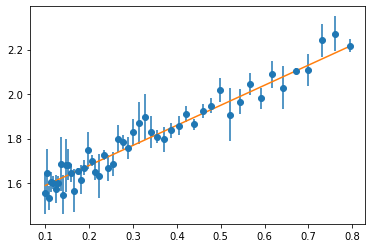

In [8]:
xGrid_1 =  np.logspace(-1,-0.1,50)
stats_1 = np.array([np.random.normal(0.02, 0.004) for i in range(len(xGrid_1))])
syst1_1 = [np.random.normal(-0.01, 0.05) for i in range(len(xGrid_1))]
syst2_1 = [np.random.normal(0.01, 0.03) for i in range(len(xGrid_1))]
systFluct_1 = [0.7, 0.8]
normErr1 = 0.00
normFluct1 = 0.8
dataGen_1 = DatasetGenerator(theoryParams1, theory1, xGrid_1, stats_1, normErr1, normFluct1, systFluct_1, syst1_1, syst2_1)

Real statistical error :  [-2.56864251e-02 -2.78682665e-01 -2.74074645e-02  4.79432827e-01
  9.35691105e-02 -1.55433689e-01  1.27655337e-01 -1.01921273e+00
  2.66420491e-02  6.59211138e-01  5.06545977e-02  1.01530265e-01
  9.56761468e-04 -4.80169106e-02  6.19920702e-01 -3.78497195e-01
  5.04139139e-02  3.21603985e-01 -1.35709303e-02  2.11777601e-01
 -2.87493997e-01  2.95089531e-02  4.59175528e-02  3.22913603e-01
 -8.86562639e-02 -1.95882076e-03 -8.83059083e-01  1.64753713e-02
  2.31870122e-03 -1.05714630e-02]
Real systematic error :  [[-0.02753274  0.01215059 -0.00197056 -0.00534435  0.00095894 -0.00883948
  -0.02259992 -0.00928185  0.00017023 -0.04400552 -0.00072388  0.01955343
  -0.0064095  -0.00360785  0.00907055  0.01814884  0.02574866 -0.00798295
   0.00111259  0.00155051 -0.03283094 -0.00976385 -0.01395183  0.03036715
   0.00444069 -0.02527574 -0.01187965  0.01135273  0.00415572 -0.00165675]
 [-0.0008588   0.06304586  0.06924047  0.01999683  0.01077176  0.03042815
   0.03687258  

,x,data,theory,stats,syst_0,syst_1,syst_2
0,0.316228,1.988461,2.021359,-0.084769,-0.055065,-0.001074,0.017650
1,0.329034,1.899437,2.030324,-0.397518,0.024301,0.078807,0.060499
2,0.342360,2.147482,2.039652,-0.088698,-0.003941,0.086551,0.056640
3,0.356225,2.518806,2.049357,0.725780,-0.010689,0.024996,-0.020531
4,0.370651,2.156567,2.059456,-0.083702,0.001918,0.013465,-0.006824
5,0.385662,1.828803,2.069963,0.168743,-0.017679,0.038035,-0.089429
6,0.401281,2.134097,2.080896,0.240483,-0.045200,0.046091,-0.073939
7,0.417532,1.102894,2.092272,-0.381514,-0.018564,0.037777,0.007412
8,0.434441,2.130948,2.104109,0.325859,0.000340,-0.017870,0.011936
9,0.452035,2.569526,2.116425,-0.326315,-0.088011,-0.078231,-0.082933


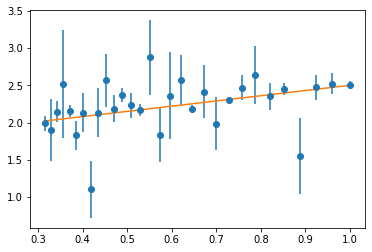

In [9]:
xGrid_2 = np.logspace(-0.5,-0.0000000001,30)
stats_2= np.array([np.random.normal(0.02, 0.3) for i in range(len(xGrid_2))])
syst1_2 = [np.random.normal(-0.005, 0.030) for i in range(len(xGrid_2))]
syst2_2 = [np.random.normal(0.015, 0.040) for i in range(len(xGrid_2))]
syst3_2 = [np.random.normal(0.02, 0.04) for i in range(len(xGrid_2))]
systFluct_2 = [0.5, 0.8, 1.2]
normErr2 = 0.0
normFluct2 = -0.99
dataGen_2 = DatasetGenerator(theoryParams2, theory2, xGrid_2, stats_2, normErr2, normFluct2, systFluct_2, syst1_2, syst2_2, syst3_2)

Real statistical error :  [-5.06782197e-01 -5.87699943e-01  1.35604077e+00 -3.39153658e-02
  1.66336880e-01 -4.59177963e-01 -1.35039747e-01 -2.66053367e+00
 -1.39144688e+00 -1.40151437e+00  7.45223556e-01  1.39003397e-03
  3.64942267e+00  5.06946117e-01  1.21331709e-02 -1.31555045e+00
 -3.16040701e+00 -3.68626389e-01 -9.84203202e-01  2.15259323e-01
 -4.74107780e-01  3.42258417e+00  2.83249743e+00 -3.20602914e-02
 -1.63952479e+00 -1.63262906e-01  1.32084270e-01 -1.04387458e-01
 -3.04214511e-01 -2.80226890e+00 -7.96427761e-01  4.27414056e-02
  3.10594328e-02 -4.41677358e+00 -2.47719728e+00 -1.84289341e+00
 -2.71871799e-02  1.02213795e-01 -1.52329945e+00 -3.07947010e-01]
Real systematic error :  []


,x,data,theory,stats
0,0.000000,1.393218,1.900000,1.508440
1,0.025641,1.325121,1.912821,1.524346
2,0.051282,3.281682,1.925641,3.385337
3,0.076923,1.904546,1.938462,0.656970
4,0.102564,2.117619,1.951282,0.685815
5,0.128205,1.504925,1.964103,2.634187
6,0.153846,1.841883,1.976923,-0.494379
7,0.179487,-0.670790,1.989744,1.537388
8,0.205128,0.611117,2.002564,1.906348
9,0.230769,0.613870,2.015385,2.702266


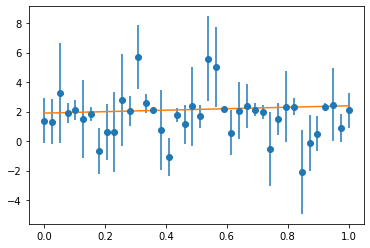

In [11]:
xGrid_3 = np.linspace(0, 1, 40)
stats_3= np.array([np.random.normal(1.5, 1.0) for i in range(len(xGrid_3))])
#syst1_3 = [np.random.normal(-0.05, 0.15) for i in range(len(xGrid_2))]
#syst2_2 = [np.random.normal(0.15, 0.2) for i in range(len(xGrid_2))]
#syst3_2 = [np.random.normal(0.2, 0.1) for i in range(len(xGrid_2))]
systFluct_3= []
normErr3 = 0.00
normFluct3 = 0.2
dataGen_3 = DatasetGenerator(theoryParams3, theory3, xGrid_3, stats_3, normErr3, normFluct3, systFluct_3)

Parameter at minimum :  [1.48905805 0.94991585]
Chisqr at minimum :  250.24265223061082
Chisqr per dof :  2.120700442632295
Number of Function Calls :  633
Parameter error using hessian method : 
 [0.00458109 0.0113416 ]


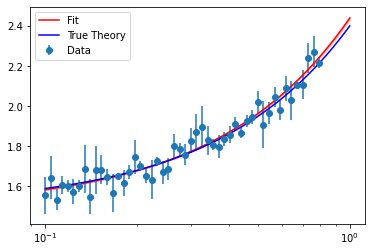

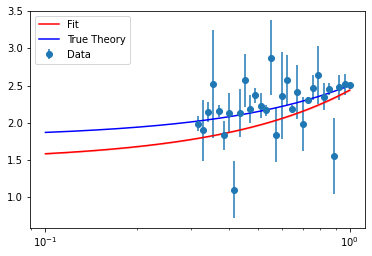

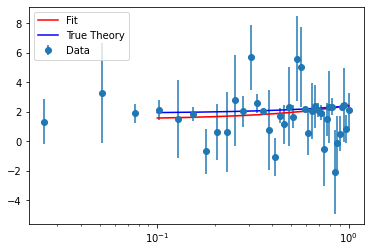

Mean parAtmin : 
 [1.49629676 0.92665453]
std parAtmin : 
 [0.00487924 0.01220307]
Mean funAtmin : 
 263.71393293234223
std funAtmin : 
 25.974844161092207
Mean z : 
 [2.32920024 2.19501612]
std z : 
 [0.97838066 1.07789502]


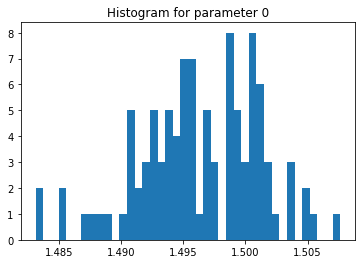

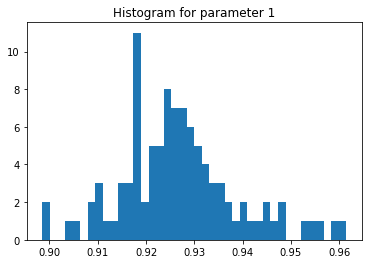

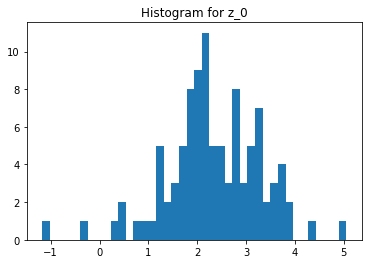

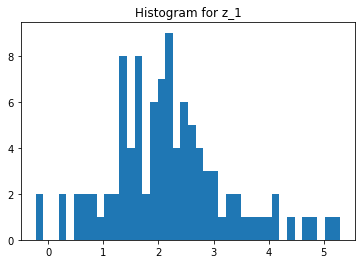

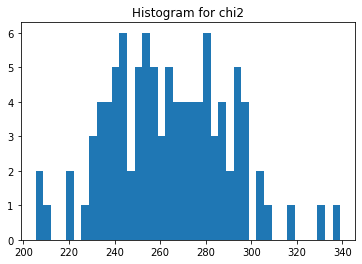

In [12]:
chi1 = ChiSquareCorr(dataGen_1, theory1)
chi2 =ChiSquareCorr(dataGen_2, theory2)
chi3 = ChiSquareCorr(dataGen_3, theory3)
                     
                     
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [(0,5), (0,3)]
globalAnalysis.runFit(bound, False)
globalAnalysis.runReplicaFits(bound, 100)

Parameter at minimum :  [1.48905804 0.94991585]
Chisqr at minimum :  250.24265223061164
Chisqr per dof :  2.120700442632302
Number of Function Calls :  627
Parameter error using hessian method : 
 [0.00458109 0.0113416 ]


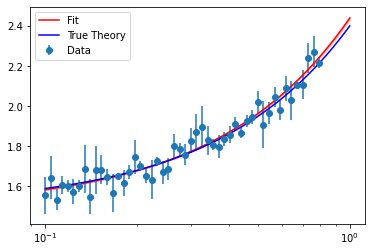

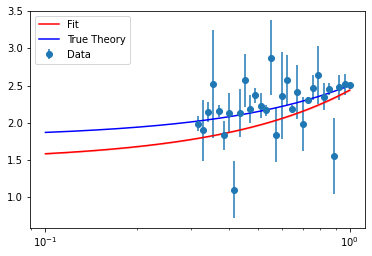

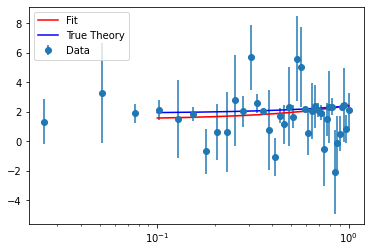

Mean parAtmin : 
 [1.48866304 0.95115896]
std parAtmin : 
 [0.00490011 0.0118648 ]
Mean funAtmin : 
 362.76667380757914
std funAtmin : 
 36.201528957064205
Mean z : 
 [2.76194107 4.33087336]
std z : 
 [1.02797711 1.05026206]


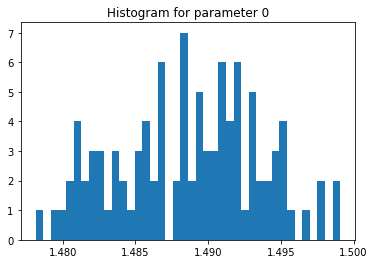

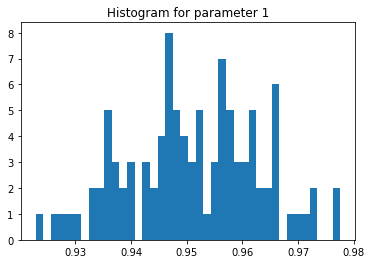

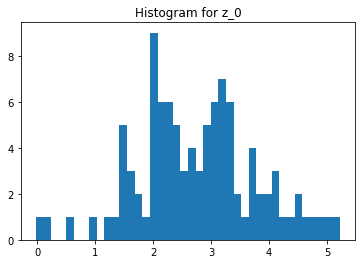

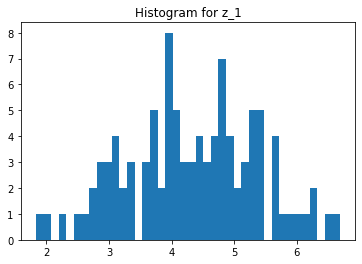

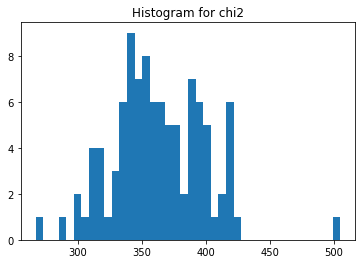

In [13]:
chi1 = ChiSquareCorr(dataGen_1, theory1)
chi2 =ChiSquareCorr(dataGen_2, theory2)
chi3 = ChiSquareCorr(dataGen_3, theory3)
                     
                     
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [(0,5), (0,3)]
globalAnalysis.runFit(bound, False)
globalAnalysis.runReplicaFits(bound, 100, False)

Parameter at minimum :  [2.0310738  0.12714106]
Chisqr at minimum :  29.232847913154803
Chisqr per dof :  0.7692854713988106
Number of Function Calls :  504
Parameter error using hessian method : 
 [0.14303037 0.32419983]


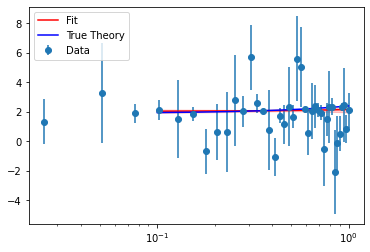

In [18]:
globalAnalysis = GlobalAnalysis(1, chi3)
bound = [(0,5), (0,3)]
globalAnalysis.runFit(bound, False)